In [ ]:
from google.colab import files
upload = files.upload()

Saving user-wallet-transactions.json to user-wallet-transactions.json


In [ ]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [ ]:
# Load the data
with open('user-wallet-transactions.json', 'r') as f:
    data = json.load(f)

# Flatten and convert to DataFrame
df = pd.json_normalize(data)

# SAFELY Extract 'amount'
if 'actionData' in df.columns:
    df['amount'] = df['actionData'].apply(lambda x: x.get('amount') if isinstance(x, dict) and 'amount' in x else 0)
elif 'actionData.amount' in df.columns:
    df['amount'] = df['actionData.amount']
else:
    df['amount'] = 0  # fallback if not found

In [ ]:

# Group by userWallet and action type — count actions
action_counts = df.groupby(['userWallet', 'action']).size().unstack(fill_value=0)

# Sum of amounts per action per wallet
amount_sums = df.groupby(['userWallet', 'action'])['amount'].sum().unstack(fill_value=0)

# Total actions per wallet
total_actions = df.groupby('userWallet').size().rename("total_actions")

# Combine all features
features = action_counts.merge(amount_sums, left_index=True, right_index=True, suffixes=('', '_amount'))
features = features.merge(total_actions, left_index=True, right_index=True)

# Reset index for processing
features.reset_index(inplace=True)

# Clean up column names
features.columns.name = 'action'

# Convert amounts to float from wei (1e18)
amount_cols = [col for col in features.columns if col.endswith('_amount')]
for col in amount_cols:
    features[col] = features[col].apply(lambda x: float(x) / 1e18 if isinstance(x, (int, float)) else 0)

# Fill missing columns if actions are not present in all rows
for col in ['deposit', 'borrow', 'repay', 'redeemunderlying', 'liquidationcall']:
    if col not in features.columns:
        features[col] = 0
for col in ['deposit_amount', 'borrow_amount', 'repay_amount', 'redeemunderlying_amount', 'liquidationcall_amount']:
    if col not in features.columns:
        features[col] = 0.0

In [ ]:
# FEATURE SCALING & CLUSTERING

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.drop(['userWallet'], axis=1))

In [ ]:
# KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
features['cluster'] = kmeans.fit_predict(scaled_features)

In [ ]:
def base_score(row):
    score = 500  # base score
    score -= 200 * row['liquidationcall']
    score += 50 * row['repay']

    borrow_amt = row['borrow_amount']
    deposit_amt = row['deposit_amount']
    if deposit_amt > 0:
        ratio = borrow_amt / deposit_amt
        score -= 300 * ratio
    elif borrow_amt > 0:
        score -= 300
    return max(0, min(1000, score))

features['base_score'] = features.apply(base_score, axis=1)

In [ ]:
# Train ML model on base_score
ml_features = features.drop(columns=['userWallet', 'base_score', 'cluster'])
y = features['base_score']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(ml_features, y)
features['score'] = model.predict(ml_features).clip(0, 1000)

# Save results
features[['userWallet', 'score', 'cluster']].to_csv("wallet_scores_ml.csv", index=False)

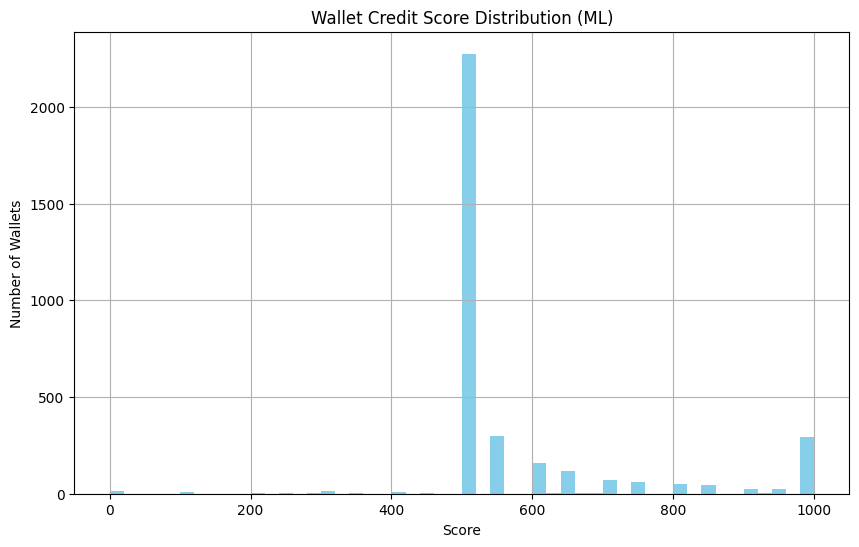

✅ Advanced ML wallet scoring complete! Output saved to wallet_scores_ml.csv


In [ ]:
plt.figure(figsize=(10,6))
plt.hist(features['score'], bins=50, color='skyblue')
plt.title("Wallet Credit Score Distribution (ML)")
plt.xlabel("Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.savefig("score_distribution_ml.png")
plt.show()

print("✅ Advanced ML wallet scoring complete! Output saved to wallet_scores_ml.csv")